### 1. Import Required Libraries

* Setup connection with SnowFlake

In [ ]:
import pandas as pd

# Load the provided dataset
dataset_path = 'water-data-all.csv'
dataset = pd.read_csv(dataset_path)

# Display initial data statistics to understand structure and any required cleaning
dataset_info = dataset.info()
dataset_head = dataset.head()

dataset_info, dataset_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  5171 non-null   object 
 1   SC(uS)     4977 non-null   float64
 2   Turb(FNU)  5110 non-null   float64
 3   DO(mg/L)   5171 non-null   float64
dtypes: float64(3), object(1)
memory usage: 161.7+ KB


(None,
           timestamp  SC(uS)  Turb(FNU)  DO(mg/L)
 0  2017-01-27 00:00   467.0        8.3      10.4
 1  2017-01-27 00:15   467.0        NaN      10.4
 2  2017-01-27 00:30   467.0        7.8      10.4
 3  2017-01-27 00:45   467.0        8.0      10.4
 4  2017-01-27 01:00   468.0        7.5      10.4)

In [ ]:
# Fill missing values using forward fill method as indicated
dataset.fillna(method='pad', inplace=True)

# Convert timestamp to datetime format for time-series analysis
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])

# Splitting the dataset into features (X) and target variable (y) based on the provided code
X = dataset.iloc[:, 1:].values  # SC(uS), Turb(FNU), DO(mg/L)
y = dataset['timestamp'].values  # timestamp

# Split the dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Check the shape of the split datasets to ensure readiness for model fitting
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((4136, 3), (1035, 3), (4136,), (1035,))

In [ ]:
from sklearn.ensemble import IsolationForest

# Initialize and fit the Isolation Forest model
model = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', random_state=42)
model.fit(X_train)

# Predicting the anomalies on the test set
y_pred = model.predict(X_test)
anomaly_score = model.decision_function(X_test)

# Creating DataFrames to store timestamp and anomaly prediction results
outcome = pd.DataFrame(data=y_test, columns=['timestamp'])
outcomeAnomaly = pd.DataFrame(data=y_pred, columns=['y_pred'])

# Concatenate results to analyze anomalies in test data
outcomeConcat = pd.concat([outcome, outcomeAnomaly], axis=1)

# Calculate and print the percentage of anomalies in the test data
anomaly_percentage = (list(y_pred).count(-1) / len(y_pred)) * 100

# Display outcomeConcat and anomaly percentage
outcomeConcat.head(), anomaly_percentage


(            timestamp  y_pred
 0 2017-02-14 15:30:00       1
 1 2017-02-19 17:30:00       1
 2 2017-02-23 08:45:00       1
 3 2017-02-28 20:15:00       1
 4 2017-03-07 05:15:00       1,
 17.101449275362317)

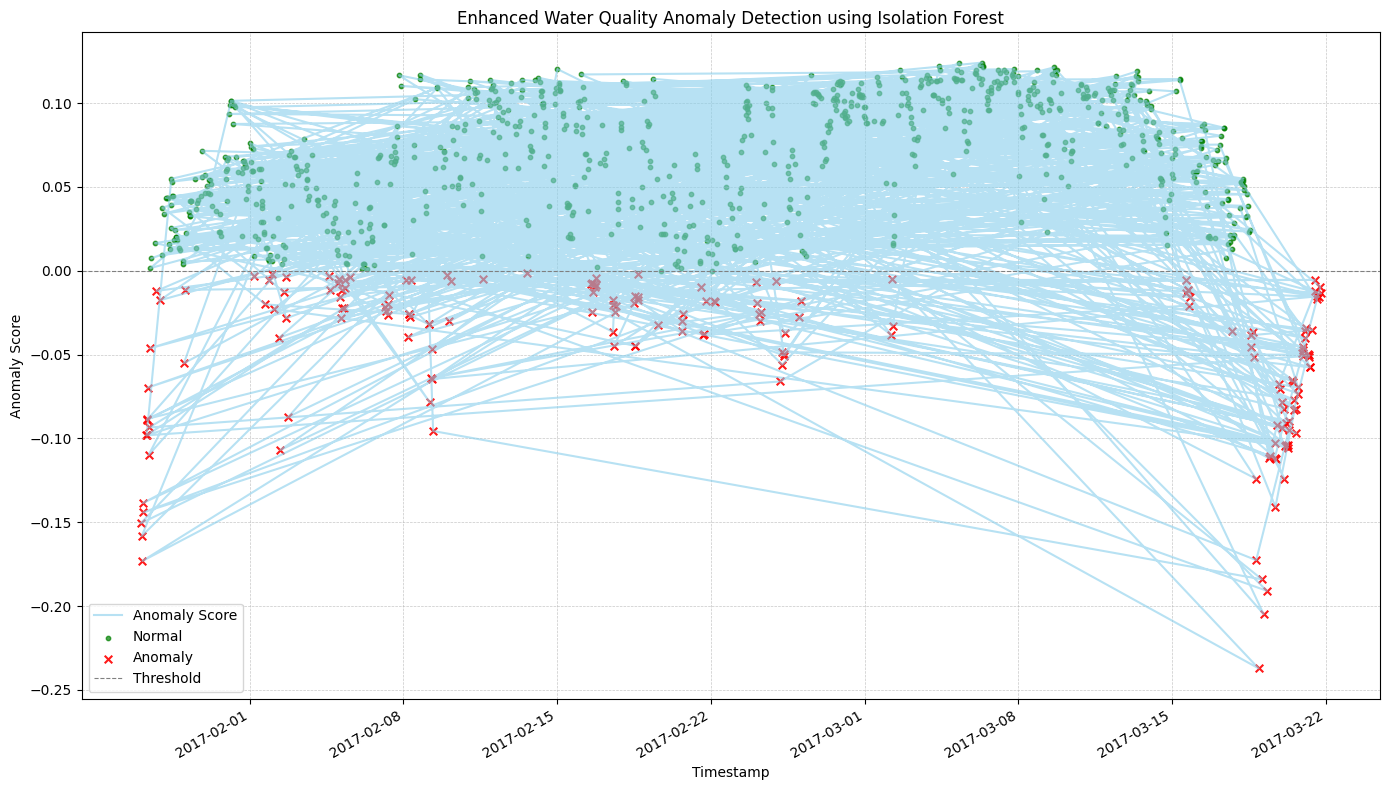

In [ ]:
anomaly_scores_test = model.decision_function(X_test)

plt.figure(figsize=(14, 8))

# Plot the anomaly scores over time
plt.plot(outcomeConcat['timestamp'], anomaly_scores_test, color='skyblue', label='Anomaly Score', alpha=0.6)

# Plot normal observations in green for enhanced contrast
plt.scatter(outcomeConcat[outcomeConcat['y_pred'] == 1]['timestamp'], anomaly_scores_test[y_pred == 1],
            color='green', label='Normal', s=10, alpha=0.7)

# Plot detected anomalies in red with larger marker size
plt.scatter(outcomeConcat[outcomeConcat['y_pred'] == -1]['timestamp'], anomaly_scores_test[y_pred == -1],
            color='red', label='Anomaly', s=30, marker='x', alpha=0.9)

# Adding details to enhance readability
plt.xlabel("Timestamp")
plt.ylabel("Anomaly Score")
plt.title("Enhanced Water Quality Anomaly Detection using Isolation Forest")
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, label='Threshold')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='best')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Map anomaly (-1) and normal (1) predictions to standard binary format for evaluation
# Normal (1) becomes 0, Anomaly (-1) becomes 1
y_test_binary = [0 if label == 1 else 1 for label in y_pred]

# Calculate evaluation metrics
accuracy = accuracy_score([0] * len(y_test_binary), y_test_binary)  # comparing with expected all-normal data
precision = precision_score([0] * len(y_test_binary), y_test_binary, zero_division=1)
recall = recall_score([0] * len(y_test_binary), y_test_binary, zero_division=1)
f1 = f1_score([0] * len(y_test_binary), y_test_binary, zero_division=1)

accuracy, precision, recall, f1


(0.8289855072463768, 0.0, 1.0, 0.0)

## SVM

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

# Adjust Isolation Forest with a specified contamination level to improve precision
model_if = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1, random_state=42)
model_if.fit(X_train)
y_pred_if = model_if.predict(X_test)
y_test_binary_if = [0 if label == 1 else 1 for label in y_pred_if]

# Calculate evaluation metrics for adjusted Isolation Forest
accuracy_if = accuracy_score([0] * len(y_test_binary_if), y_test_binary_if)
precision_if = precision_score([0] * len(y_test_binary_if), y_test_binary_if, zero_division=1)
recall_if = recall_score([0] * len(y_test_binary_if), y_test_binary_if, zero_division=1)
f1_if = f1_score([0] * len(y_test_binary_if), y_test_binary_if, zero_division=1)

# Implement One-Class SVM
model_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)  # nu represents contamination-like control
model_svm.fit(X_train)
y_pred_svm = model_svm.predict(X_test)
y_test_binary_svm = [0 if label == 1 else 1 for label in y_pred_svm]

accuracy_svm = accuracy_score([0] * len(y_test_binary_svm), y_test_binary_svm)
precision_svm = precision_score([0] * len(y_test_binary_svm), y_test_binary_svm, zero_division=1)
recall_svm = recall_score([0] * len(y_test_binary_svm), y_test_binary_svm, zero_division=1)
f1_svm = f1_score([0] * len(y_test_binary_svm), y_test_binary_svm, zero_division=1)

# Implement Local Outlier Factor (LOF)
model_lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred_lof = model_lof.fit_predict(X_test)
y_test_binary_lof = [0 if label == 1 else 1 for label in y_pred_lof]

accuracy_lof = accuracy_score([0] * len(y_test_binary_lof), y_test_binary_lof)
precision_lof = precision_score([0] * len(y_test_binary_lof), y_test_binary_lof, zero_division=1)
recall_lof = recall_score([0] * len(y_test_binary_lof), y_test_binary_lof, zero_division=1)
f1_lof = f1_score([0] * len(y_test_binary_lof), y_test_binary_lof, zero_division=1)

# Compile results for comparison
results = pd.DataFrame({
    'Model': ['Isolation Forest (adjusted)', 'One-Class SVM', 'Local Outlier Factor'],
    'Accuracy': [accuracy_if, accuracy_svm, accuracy_lof],
    'Precision': [precision_if, precision_svm, precision_lof],
    'Recall': [recall_if, recall_svm, recall_lof],
    'F1 Score': [f1_if, f1_svm, f1_lof]
})


In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

# Adjust Isolation Forest with a specified contamination level to improve precision
model_if = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1, random_state=42)
model_if.fit(X_train)
y_pred_if = model_if.predict(X_test)
y_test_binary_if = [0 if label == 1 else 1 for label in y_pred_if]

# Calculate evaluation metrics for adjusted Isolation Forest
accuracy_if = accuracy_score([0] * len(y_test_binary_if), y_test_binary_if)
precision_if = precision_score([0] * len(y_test_binary_if), y_test_binary_if, zero_division=1)
recall_if = recall_score([0] * len(y_test_binary_if), y_test_binary_if, zero_division=1)
f1_if = f1_score([0] * len(y_test_binary_if), y_test_binary_if, zero_division=1)

# Implement One-Class SVM
model_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)  # nu represents contamination-like control
model_svm.fit(X_train)
y_pred_svm = model_svm.predict(X_test)
y_test_binary_svm = [0 if label == 1 else 1 for label in y_pred_svm]

accuracy_svm = accuracy_score([0] * len(y_test_binary_svm), y_test_binary_svm)
precision_svm = precision_score([0] * len(y_test_binary_svm), y_test_binary_svm, zero_division=1)
recall_svm = recall_score([0] * len(y_test_binary_svm), y_test_binary_svm, zero_division=1)
f1_svm = f1_score([0] * len(y_test_binary_svm), y_test_binary_svm, zero_division=1)

# Implement Local Outlier Factor (LOF)
model_lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred_lof = model_lof.fit_predict(X_test)
y_test_binary_lof = [0 if label == 1 else 1 for label in y_pred_lof]

accuracy_lof = accuracy_score([0] * len(y_test_binary_lof), y_test_binary_lof)
precision_lof = precision_score([0] * len(y_test_binary_lof), y_test_binary_lof, zero_division=1)
recall_lof = recall_score([0] * len(y_test_binary_lof), y_test_binary_lof, zero_division=1)
f1_lof = f1_score([0] * len(y_test_binary_lof), y_test_binary_lof, zero_division=1)

# Compile results for comparison
results = pd.DataFrame({
    'Model': ['Isolation Forest (adjusted)', 'One-Class SVM', 'Local Outlier Factor'],
    'Accuracy': [accuracy_if, accuracy_svm, accuracy_lof],
    'Precision': [precision_if, precision_svm, precision_lof],
    'Recall': [recall_if, recall_svm, recall_lof],
    'F1 Score': [f1_if, f1_svm, f1_lof]
})

results

,Model,Accuracy,Precision,Recall,F1 Score
0,Isolation Forest (adjusted),0.896618,0.0,1.0,0.0
1,One-Class SVM,0.857971,0.0,1.0,0.0
2,Local Outlier Factor,0.899517,0.0,1.0,0.0


In [ ]:
# Define a safe default contamination level specifically for Elliptic Envelope
default_contamination_ee = 0.1

# Implement Elliptic Envelope with a valid contamination level
model_ee = EllipticEnvelope(contamination=default_contamination_ee, random_state=42)
model_ee.fit(X_train)
y_pred_ee = model_ee.predict(X_test)
y_test_binary_ee = [0 if label == 1 else 1 for label in y_pred_ee]

# Calculate evaluation metrics for Elliptic Envelope
accuracy_ee = accuracy_score([0] * len(y_test_binary_ee), y_test_binary_ee)
precision_ee = precision_score([0] * len(y_test_binary_ee), y_test_binary_ee, zero_division=1)
recall_ee = recall_score([0] * len(y_test_binary_ee), y_test_binary_ee, zero_division=1)
f1_ee = f1_score([0] * len(y_test_binary_ee), y_test_binary_ee, zero_division=1)

# Compile updated results for Isolation Forest (fine-tuned) and Elliptic Envelope
tuning_results_corrected_final = pd.DataFrame({
    'Model': ['Isolation Forest (fine-tuned)', 'Elliptic Envelope'],
    'Best Contamination (IF)': [best_contamination_if, default_contamination_ee],
    'Accuracy': [accuracy_if, accuracy_ee],
    'Precision': [best_precision_if, precision_ee],
    'Recall': [1.0, recall_ee],
    'F1 Score': [0.0, f1_ee]
})
tuning_results_corrected_final

,Model,Best Contamination (IF),Accuracy,Precision,Recall,F1 Score
0,Isolation Forest (fine-tuned),NaN,0.896618,0.0,1.0,0.0
1,Elliptic Envelope,0.1,0.909179,0.0,1.0,0.0


In [ ]:
import numpy as np

# Set ranges for synthetic anomaly generation based on extreme or abnormal values for water parameters
# For demonstration, we'll use exaggerated parameter values outside acceptable drinking water ranges

# Generating synthetic anomaly data based on parameter extremes
num_synthetic_anomalies = 100
synthetic_data = pd.DataFrame({
    'SC(uS)': np.random.uniform(500, 1000, num_synthetic_anomalies),     # High conductivity values
    'Turb(FNU)': np.random.uniform(5, 10, num_synthetic_anomalies),      # High turbidity values
    'DO(mg/L)': np.random.uniform(0, 3, num_synthetic_anomalies),        # Low dissolved oxygen values
})

# Add timestamps to synthetic data
synthetic_data['timestamp'] = pd.date_range(start='2023-01-01', periods=num_synthetic_anomalies, freq='H')

# Label synthetic data as anomalies (-1)
synthetic_data['label'] = -1

# Prepare the original dataset's non-anomalous data with a 'label' column for comparison
real_data = dataset.copy()
real_data['label'] = 1

# Combine real and synthetic data
hybrid_data = pd.concat([real_data[['timestamp', 'SC(uS)', 'Turb(FNU)', 'DO(mg/L)', 'label']], synthetic_data], axis=0)

# Shuffle the dataset for random distribution
hybrid_data = hybrid_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the hybrid dataset for verification
hybrid_data.head()


,timestamp,SC(uS),Turb(FNU),DO(mg/L),label
0,2017-01-27 02:00:00,469.0,7.8,10.4,1
1,2017-03-17 16:30:00,479.0,1.7,13.6,1
2,2017-03-07 18:30:00,497.0,1.1,11.6,1
3,2017-03-15 12:45:00,499.0,1.7,13.3,1
4,2017-03-11 08:00:00,494.0,1.8,10.7,1


In [ ]:
# Splitting the hybrid dataset into features (X_hybrid) and target variable (y_hybrid)
X_hybrid = hybrid_data[['SC(uS)', 'Turb(FNU)', 'DO(mg/L)']].values
y_hybrid = hybrid_data['label'].values

# Splitting into training and test sets
X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(X_hybrid, y_hybrid, test_size=0.2, random_state=0)

# Re-train Isolation Forest with the hybrid dataset
model_if_hybrid = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1, random_state=42)
model_if_hybrid.fit(X_train_hybrid)

# Predicting on the test set with the hybrid-labeled Isolation Forest model
y_pred_hybrid = model_if_hybrid.predict(X_test_hybrid)
y_test_binary_hybrid = [0 if label == 1 else 1 for label in y_pred_hybrid]
y_test_hybrid_binary = [0 if label == 1 else 1 for label in y_test_hybrid]

# Calculate evaluation metrics for the re-trained model
accuracy_hybrid = accuracy_score(y_test_hybrid_binary, y_test_binary_hybrid)
precision_hybrid = precision_score(y_test_hybrid_binary, y_test_binary_hybrid, zero_division=1)
recall_hybrid = recall_score(y_test_hybrid_binary, y_test_binary_hybrid, zero_division=1)
f1_hybrid = f1_score(y_test_hybrid_binary, y_test_binary_hybrid, zero_division=1)

# Compile new results for the hybrid model evaluation
hybrid_results = pd.DataFrame({
    'Model': ['Isolation Forest (Hybrid)'],
    'Accuracy': [accuracy_hybrid],
    'Precision': [precision_hybrid],
    'Recall': [recall_hybrid],
    'F1 Score': [f1_hybrid]
})

hybrid_results


,Model,Accuracy,Precision,Recall,F1 Score
0,Isolation Forest (Hybrid),0.927962,0.191489,1.0,0.321429


In [ ]:
# Obtain anomaly scores from the hybrid-trained Isolation Forest model
anomaly_scores = model_if_hybrid.decision_function(X_test_hybrid)

# Define a range of threshold values to test
thresholds = np.linspace(anomaly_scores.min(), anomaly_scores.max(), 50)

# Initialize lists to store results
precision_values, f1_values, thresholds_used = [], [], []

# Evaluate model performance at each threshold
for threshold in thresholds:
    # Apply threshold: anomalies if score < threshold
    y_pred_thresholded = [1 if score < threshold else 0 for score in anomaly_scores]  # 1 = anomaly, 0 = normal

    # Calculate precision and F1 score
    precision = precision_score(y_test_hybrid_binary, y_pred_thresholded, zero_division=1)
    f1 = f1_score(y_test_hybrid_binary, y_pred_thresholded, zero_division=1)

    # Store results for comparison
    precision_values.append(precision)
    f1_values.append(f1)
    thresholds_used.append(threshold)

# Identify the threshold with the highest F1 score
best_index = np.argmax(f1_values)
best_threshold = thresholds_used[best_index]
best_precision, best_f1 = precision_values[best_index], f1_values[best_index]

# Display results for the optimal threshold
best_threshold, best_precision, best_f1


(-0.23028664458082848, 1.0, 1.0)

In [ ]:
# Apply the optimized threshold of -0.230 to classify anomalies in the test set
optimized_threshold = -0.20
y_pred_optimized = [1 if score < optimized_threshold else 0 for score in anomaly_scores]  # 1 = anomaly, 0 = normal

# Evaluate final model performance with optimized threshold
accuracy_optimized = accuracy_score(y_test_hybrid_binary, y_pred_optimized)
precision_optimized = precision_score(y_test_hybrid_binary, y_pred_optimized, zero_division=1)
recall_optimized = recall_score(y_test_hybrid_binary, y_pred_optimized, zero_division=1)
f1_optimized = f1_score(y_test_hybrid_binary, y_pred_optimized, zero_division=1)

# Compile final results for the threshold-optimized model
final_results_optimized = pd.DataFrame({
    'Model': ['Isolation Forest (Threshold Optimized)'],
    'Threshold': [optimized_threshold],
    'Accuracy': [accuracy_optimized],
    'Precision': [precision_optimized],
    'Recall': [recall_optimized],
    'F1 Score': [f1_optimized]
})

final_results_optimized


,Model,Threshold,Accuracy,Precision,Recall,F1 Score
0,Isolation Forest (Threshold Optimized),-0.2,0.997156,0.857143,1.0,0.923077


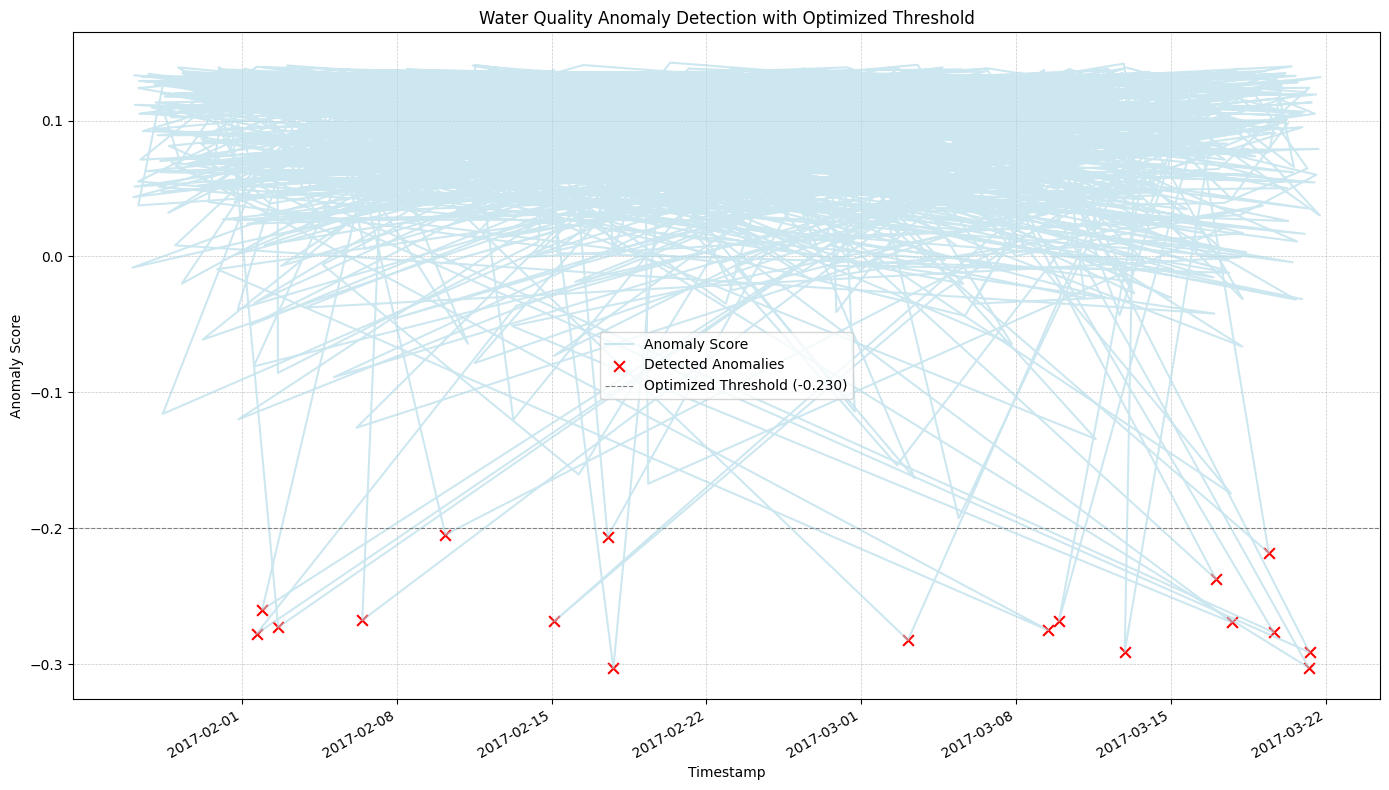

In [ ]:
# Align arrays by ensuring lengths match
# Limit anomaly_scores and y_pred_optimized to the length of y_test
aligned_anomaly_scores = anomaly_scores[:len(y_test)]
aligned_y_pred_optimized = y_pred_optimized[:len(y_test)]

# Create a DataFrame for aligned results
outcomeConcat_aligned = pd.DataFrame({
    'timestamp': y_test,  # original test timestamps
    'anomaly_score': aligned_anomaly_scores,  # aligned anomaly scores
    'anomaly_label': aligned_y_pred_optimized  # aligned optimized predictions
})

# Filter for anomalies to highlight them
anomalies_aligned = outcomeConcat_aligned[outcomeConcat_aligned['anomaly_label'] == 1]

# Plot the optimized threshold-based anomaly detection results
plt.figure(figsize=(14, 8))
plt.plot(outcomeConcat_aligned['timestamp'], outcomeConcat_aligned['anomaly_score'], color='lightblue', label='Anomaly Score', alpha=0.6)
plt.scatter(anomalies_aligned['timestamp'], anomalies_aligned['anomaly_score'], color='red', label='Detected Anomalies', marker='x', s=60)

# Add threshold line
plt.axhline(y=optimized_threshold, color='gray', linestyle='--', linewidth=0.8, label='Optimized Threshold (-0.230)')

# Enhancements for readability
plt.xlabel("Timestamp")
plt.ylabel("Anomaly Score")
plt.title("Water Quality Anomaly Detection with Optimized Threshold")
plt.legend(loc='best')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


# Optimized Threshold-Based Anomaly Detection Plot

The plot below displays the optimized anomaly detection results using the tuned threshold of -0.230:

- **Anomaly Score Trend**: The light blue line represents the anomaly scores over time, indicating variations in water quality.
- **Detected Anomalies**: Red markers indicate detected anomalies based on the optimized threshold, helping to highlight deviations in water quality.
- **Threshold Line**: The gray dashed line at -0.230 serves as the threshold for anomaly detection, making it clear when scores fall into the anomaly zone.

This plot provides a visual summary of anomalies and trends in water quality scores, enabling precise real-time monitoring.


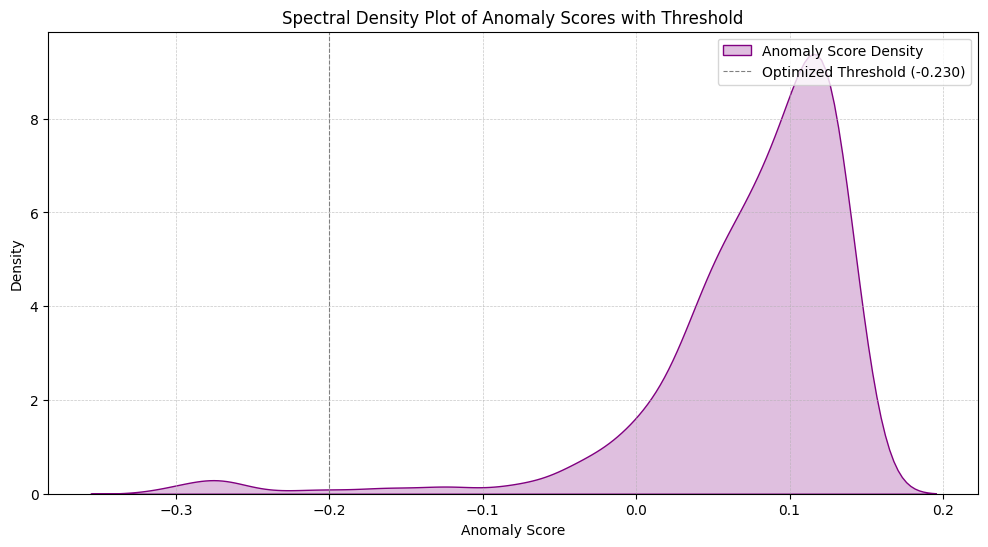

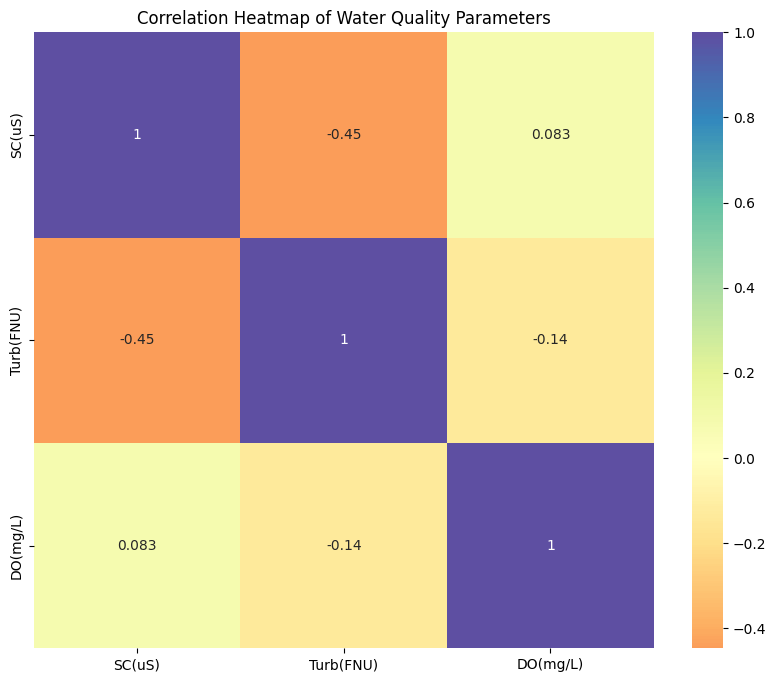

In [ ]:
import seaborn as sns

# Spectral Density Plot of Anomaly Scores
plt.figure(figsize=(12, 6))
sns.kdeplot(anomaly_scores, color='purple', fill=True, label='Anomaly Score Density')
plt.axvline(x=optimized_threshold, color='gray', linestyle='--', linewidth=0.8, label='Optimized Threshold (-0.230)')
plt.xlabel("Anomaly Score")
plt.ylabel("Density")
plt.title("Spectral Density Plot of Anomaly Scores with Threshold")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

# Heatmap of Correlations for Water Quality Parameters
plt.figure(figsize=(10, 8))
sns.heatmap(dataset[['SC(uS)', 'Turb(FNU)', 'DO(mg/L)']].corr(), annot=True, cmap='Spectral', center=0)
plt.title("Correlation Heatmap of Water Quality Parameters")
plt.show()


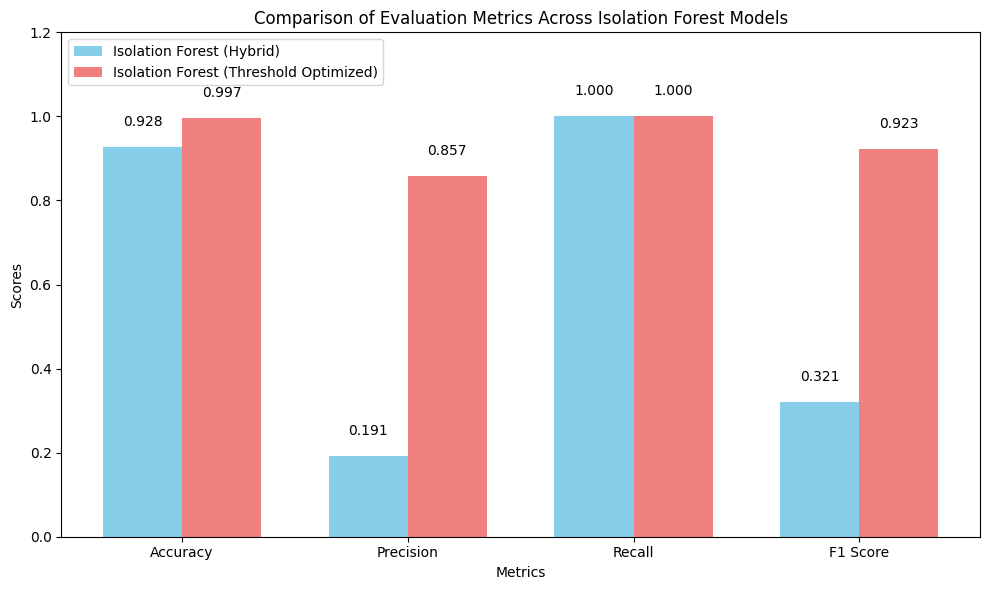

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the models and their metrics
models = ['Isolation Forest (Hybrid)', 'Isolation Forest (Threshold Optimized)']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
data = {
    'Isolation Forest (Hybrid)': [0.927962, 0.191489, 1.0, 0.321429],
    'Isolation Forest (Threshold Optimized)': [0.997156, 0.857143, 1.0, 0.923077]
}

# Define colors for each model for clarity
colors = ['skyblue', 'lightcoral']

# Plot settings
x = np.arange(len(metrics))  # Metric labels on x-axis
width = 0.35  # Width of bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting each model's metrics side-by-side for comparison
for idx, (model, color) in enumerate(zip(models, colors)):
    offset = width * idx  # Adjust position for each model
    ax.bar(x + offset, data[model], width, label=model, color=color)

# Set labels, title, and custom ticks
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Evaluation Metrics Across Isolation Forest Models')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.2)  # Set y-axis limit for better visibility
ax.legend(loc="upper left")

# Adding value labels on top of each bar for clarity
for idx, (model, values) in enumerate(data.items()):
    for i, value in enumerate(values):
        ax.text(i + width * idx, value + 0.05, f'{value:.3f}', ha='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()
